# Imputacion de Datos Faltantes para la Precipitacion del Meta mediante modelación XGBOOST

Este Jupyter Notebook se enfoca en el desarrolo metodologico del trabajo de grado de los estudiantes Ronaldo Hernandez Mejia y Hector Freddy Velasco, en el cual se enfoca en la imputaciopn de datos faltnates para la variable de precipitacion en el departamento del Meta, Colombia. Con una gran volumen de datos de la informacion diaria de la precipitacion desde 1980 hasta el 2016, seleccionando un total de 56 Estaciones meteorologias del IDEAM.

La región del Meta es muy importante en este país por la diversidad del clima y su efecto sobre la agricultura y otros sectores económicos. La variabilidad de las precipitaciones juega un papel importante en el análisis del clima y la toma de decisiones relacionadas con  la gestión del agua y el clima. 

El objetivo principal es desarrolar un modelo basado en el algotimo K-Nearest Neighbors(KNN) para imputar los datos faltantes de precipitacion, utilizando un conjunto de datos que contiene mas de 700.000 observaciones. 

Dada la gran cantidad de datos se ha implementado una version que utiliza los cores del procesador para ejecutar el modelo en paralelo optimizando asi el tiempo de ejecucion, mejorando la eficiencia computacional y acelerar el proceso, tambien por este motivo el desarrolo en python tiene tiempos de respuesta cortos en el manejo de datos.



### instalacion de librerias

In [1]:
import subprocess
import sys
import importlib

def install_and_import(package):
    try:
        importlib.import_module(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    finally:
        globals()[package] = importlib.import_module(package)


In [2]:
packages = ['pandas', 'IPython', 'pandasgui', 'numpy', 'matplotlib','joblib','sklearn']

for package in packages:
    install_and_import(package)


En caso de que no funcione instalacion manual:

In [3]:
import os
#observar donde estoy en ruta 
os.getcwd()

'c:\\Users\\vhect\\Desktop\\tesis codigos'

ruta ronaldo 

In [4]:
# import os
# current_path = os.getcwd()
# print(f"Ruta actual del directorio de trabajo: {current_path}")
# new_path = "F:\\TESIS\\Proyecto_mod_precipitacion"
# os.chdir(new_path)
# new_current_path = os.getcwd()
# print(f"Nueva ruta del directorio de trabajo: {new_current_path}")

ruta hector 


In [5]:
import os
current_path = os.getcwd()
print(f"Ruta actual del directorio de trabajo: {current_path}")
new_path = "c:\\Users\\vhect\\Documents\\semestre 10\\TESIS\\Proyecto_mod_precipitacion"
os.chdir(new_path)
new_current_path = os.getcwd()
print(f"Nueva ruta del directorio de trabajo: {new_current_path}")

Ruta actual del directorio de trabajo: c:\Users\vhect\Desktop\tesis codigos
Nueva ruta del directorio de trabajo: c:\Users\vhect\Documents\semestre 10\TESIS\Proyecto_mod_precipitacion


### Lectura de datos

In [6]:
import pandas as pd

In [7]:
data = pd.read_csv("Datos/datos_seleccionados_para_modelo_coordenadas.txt",sep=";")
data.head()

,Date,prec,ID,LAT,LON
0,1983-06-09,6.8,32010010,2.562833,-74.103083
1,1983-06-10,17.8,32010010,2.562833,-74.103083
2,1983-06-11,0.0,32010010,2.562833,-74.103083
3,1983-06-12,0.5,32010010,2.562833,-74.103083
4,1983-06-13,6.9,32010010,2.562833,-74.103083


Estructura de los datos

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656436 entries, 0 to 656435
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Date    656436 non-null  object 
 1   prec    592124 non-null  float64
 2   ID      656436 non-null  int64  
 3   LAT     656436 non-null  float64
 4   LON     656436 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 25.0+ MB


Visualizacion de los datos faltantes 

<Figure size 1000x600 with 0 Axes>

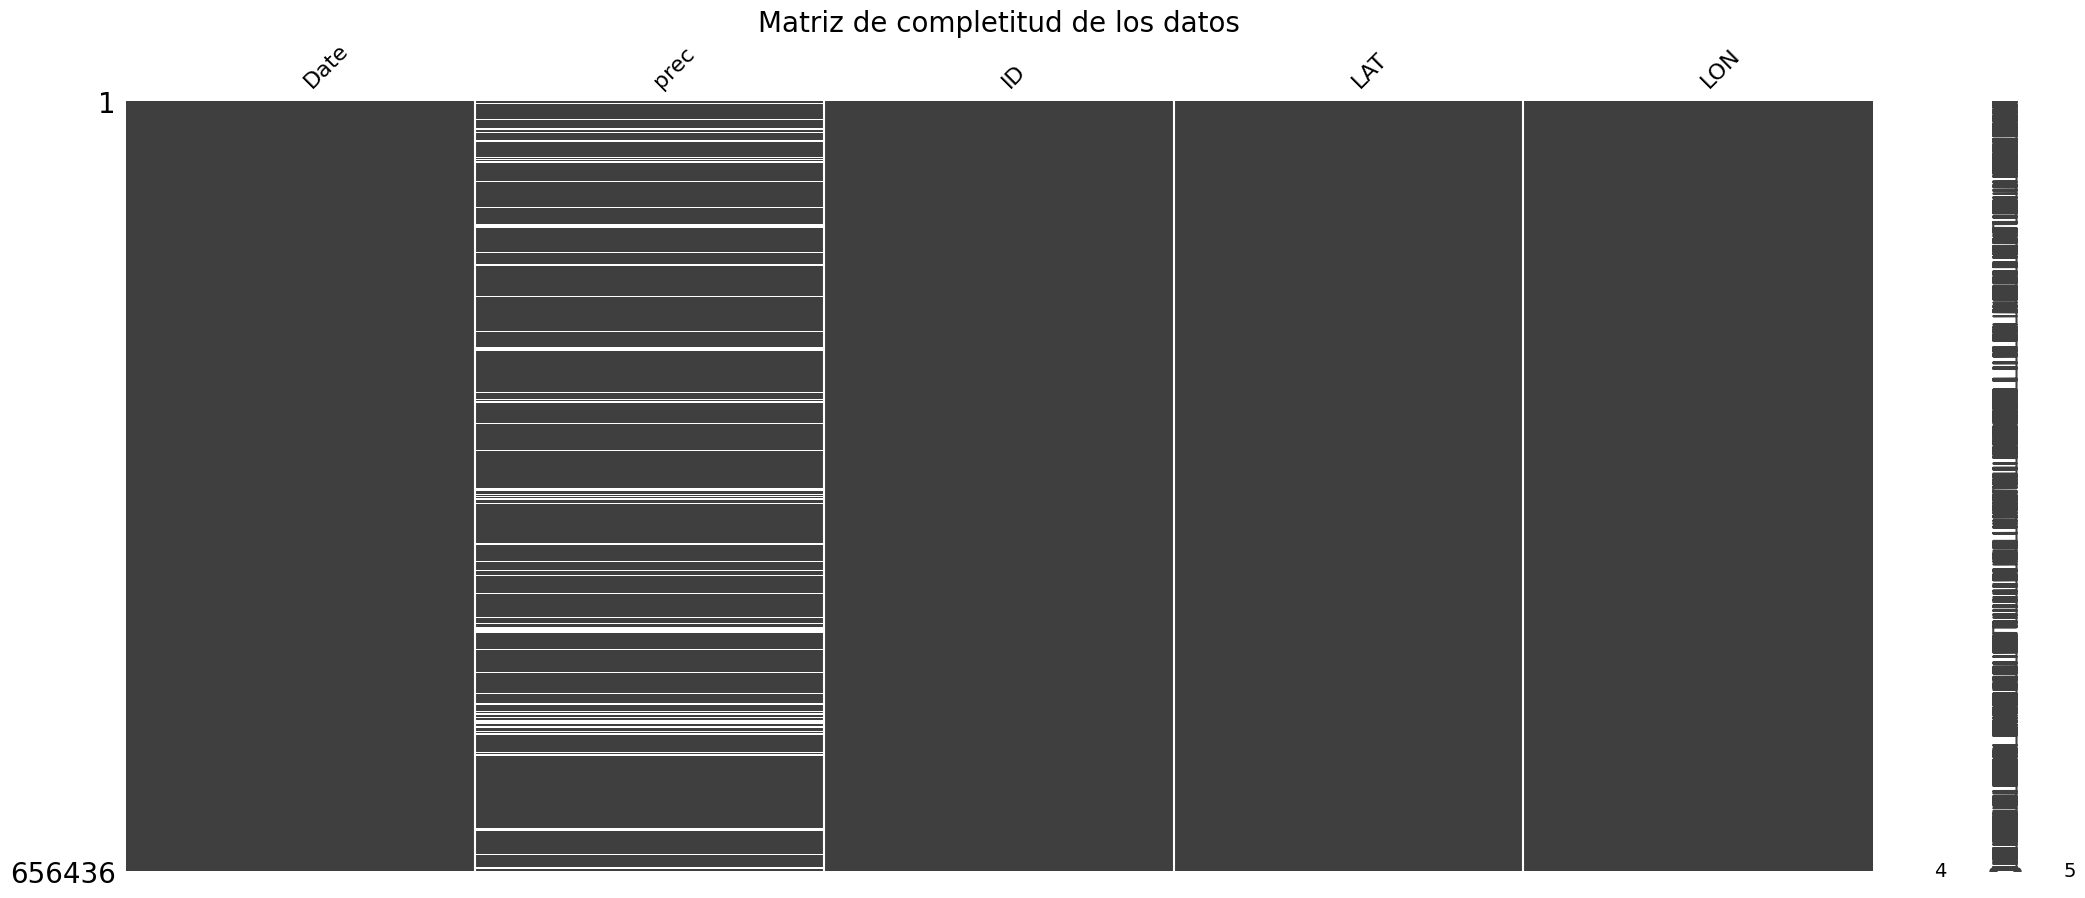

<Figure size 1000x600 with 0 Axes>

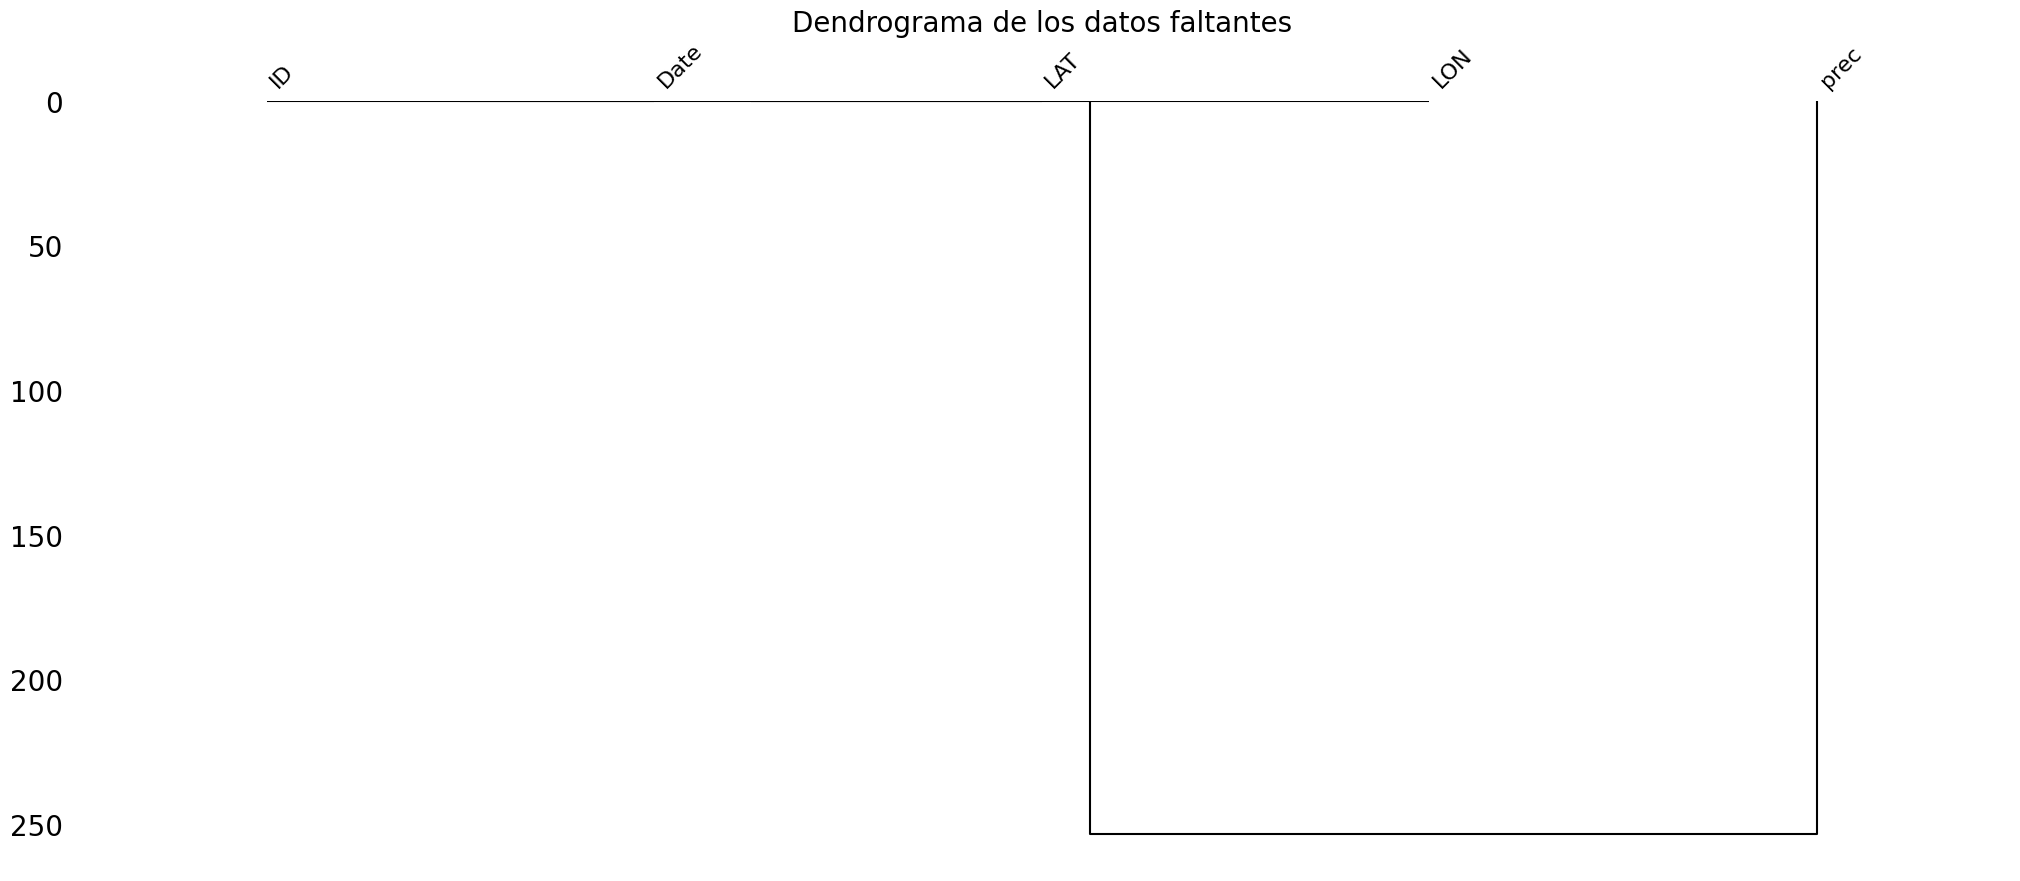

Date        0
prec    64312
ID          0
LAT         0
LON         0
dtype: int64


In [9]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

# Suponemos que 'data' es tu DataFrame

# Visualizar la completitud de los datos con matriz
plt.figure(figsize=(10,6))
msno.matrix(data)
plt.title('Matriz de completitud de los datos', fontsize=20)
plt.show()

# Agrupar las columnas con datos faltantes similares con dendrograma
plt.figure(figsize=(10,6))
msno.dendrogram(data)
plt.title('Dendrograma de los datos faltantes', fontsize=20)
plt.show()

# Resumen de la cantidad de datos faltantes por columna
print(data.isnull().sum())


### Correccion de variables para el modelo

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656436 entries, 0 to 656435
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Date    656436 non-null  object 
 1   prec    592124 non-null  float64
 2   ID      656436 non-null  int64  
 3   LAT     656436 non-null  float64
 4   LON     656436 non-null  float64
dtypes: float64(3), int64(1), object(1)
memory usage: 25.0+ MB


In [11]:
# Asegurarte de que 'Date' es una columna datetime
data['Date'] = pd.to_datetime(data['Date'])

# Crear nuevas columnas para el año, mes y día
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day

# Crear un nuevo dataframe con las columnas deseadas
new_data = data[['ID', 'Year', 'Month', 'Day', 'prec', 'LAT', 'LON']].copy()


In [12]:
new_data = new_data.sort_values('ID')


In [13]:
new_data.head(10)

,ID,Year,Month,Day,prec,LAT,LON
0,32010010,1983,6,9,6.8,2.562833,-74.103083
8045,32010010,2005,6,18,8.0,2.562833,-74.103083
8046,32010010,2005,6,19,12.0,2.562833,-74.103083
8047,32010010,2005,6,20,0.0,2.562833,-74.103083
8048,32010010,2005,6,21,4.0,2.562833,-74.103083
8049,32010010,2005,6,22,0.0,2.562833,-74.103083
8050,32010010,2005,6,23,3.0,2.562833,-74.103083
8051,32010010,2005,6,24,41.0,2.562833,-74.103083
8052,32010010,2005,6,25,8.0,2.562833,-74.103083
8053,32010010,2005,6,26,3.0,2.562833,-74.103083


In [14]:
new_data = new_data.rename(columns={
    'Year': 'Año',
    'Month': 'Mes',
    'Day': 'Día',
    'prec': 'prec',
    'LAT': 'LAT',
    'LON': 'LON'
})


In [15]:
new_data = new_data[['Año', 'Mes', 'Día', 'prec', 'LAT', 'LON']]


In [16]:
new_data.head(5)

,Año,Mes,Día,prec,LAT,LON
0,1983,6,9,6.8,2.562833,-74.103083
8045,2005,6,18,8.0,2.562833,-74.103083
8046,2005,6,19,12.0,2.562833,-74.103083
8047,2005,6,20,0.0,2.562833,-74.103083
8048,2005,6,21,4.0,2.562833,-74.103083


In [17]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 656436 entries, 0 to 656435
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Año     656436 non-null  int32  
 1   Mes     656436 non-null  int32  
 2   Día     656436 non-null  int32  
 3   prec    592124 non-null  float64
 4   LAT     656436 non-null  float64
 5   LON     656436 non-null  float64
dtypes: float64(3), int32(3)
memory usage: 27.5 MB


### Separacion de datos completos y faltantes

Surge de la necesidad de tener la data completa para tener el registro de los datos observados reales, los cuales son los que brindaran el soporte a las matricas estadisticas de desempeño como el RMSE,MAE,PRMSE

In [18]:
# Separar los datos completos de los datos con valores faltantes en 'Prec'
data_completa = new_data.dropna(subset=['prec'])
data_faltantes = new_data[new_data['prec'].isna()]


In [19]:
data_faltantes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64312 entries, 8801 to 654274
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Año     64312 non-null  int32  
 1   Mes     64312 non-null  int32  
 2   Día     64312 non-null  int32  
 3   prec    0 non-null      float64
 4   LAT     64312 non-null  float64
 5   LON     64312 non-null  float64
dtypes: float64(3), int32(3)
memory usage: 2.7 MB


In [20]:
data_completa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 592124 entries, 0 to 656435
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Año     592124 non-null  int32  
 1   Mes     592124 non-null  int32  
 2   Día     592124 non-null  int32  
 3   prec    592124 non-null  float64
 4   LAT     592124 non-null  float64
 5   LON     592124 non-null  float64
dtypes: float64(3), int32(3)
memory usage: 24.8 MB


Ahora para simular los datos faltantes reales del 8.27%, se imputaran el 10% de datos faltantes por medio de una funcion aletoria para un total de 59.212 datos faltantes, la funcion toma aletoriamente las posiciones de la variable seleccionada y realizara un extraccion de la informacion, dejando asi un registro faltante como resultado.

Esto con el objetivo de simular la situacion del modelo en una naturaleza de los datos completamente al azar 

In [21]:
import numpy as np

def insertar_nan_aleatoriamente(df, nombre_columna, fraccion):
    df = df.copy()
    df['Original'] = df[nombre_columna]
    indices_a_modificar = df[nombre_columna].dropna().sample(frac=fraccion).index
    df.loc[indices_a_modificar, nombre_columna] = np.nan
    return df

# Insertar aleatoriamente NaN en el 20% de los datos
data_completa_mod = insertar_nan_aleatoriamente(data_completa, 'prec', 0.1)


In [22]:
data_completa_mod.info()
data_completa_mod.head(10)

<class 'pandas.core.frame.DataFrame'>
Index: 592124 entries, 0 to 656435
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Año       592124 non-null  int32  
 1   Mes       592124 non-null  int32  
 2   Día       592124 non-null  int32  
 3   prec      532912 non-null  float64
 4   LAT       592124 non-null  float64
 5   LON       592124 non-null  float64
 6   Original  592124 non-null  float64
dtypes: float64(4), int32(3)
memory usage: 45.5 MB


,Año,Mes,Día,prec,LAT,LON,Original
0,1983,6,9,6.8,2.562833,-74.103083,6.8
8045,2005,6,18,8.0,2.562833,-74.103083,8.0
8046,2005,6,19,12.0,2.562833,-74.103083,12.0
8047,2005,6,20,0.0,2.562833,-74.103083,0.0
8048,2005,6,21,4.0,2.562833,-74.103083,4.0
8049,2005,6,22,0.0,2.562833,-74.103083,0.0
8050,2005,6,23,3.0,2.562833,-74.103083,3.0
8051,2005,6,24,41.0,2.562833,-74.103083,41.0
8052,2005,6,25,8.0,2.562833,-74.103083,8.0
8053,2005,6,26,3.0,2.562833,-74.103083,3.0


Visualiuzacion datos faltantes para la data completa modificada

<Figure size 1000x600 with 0 Axes>

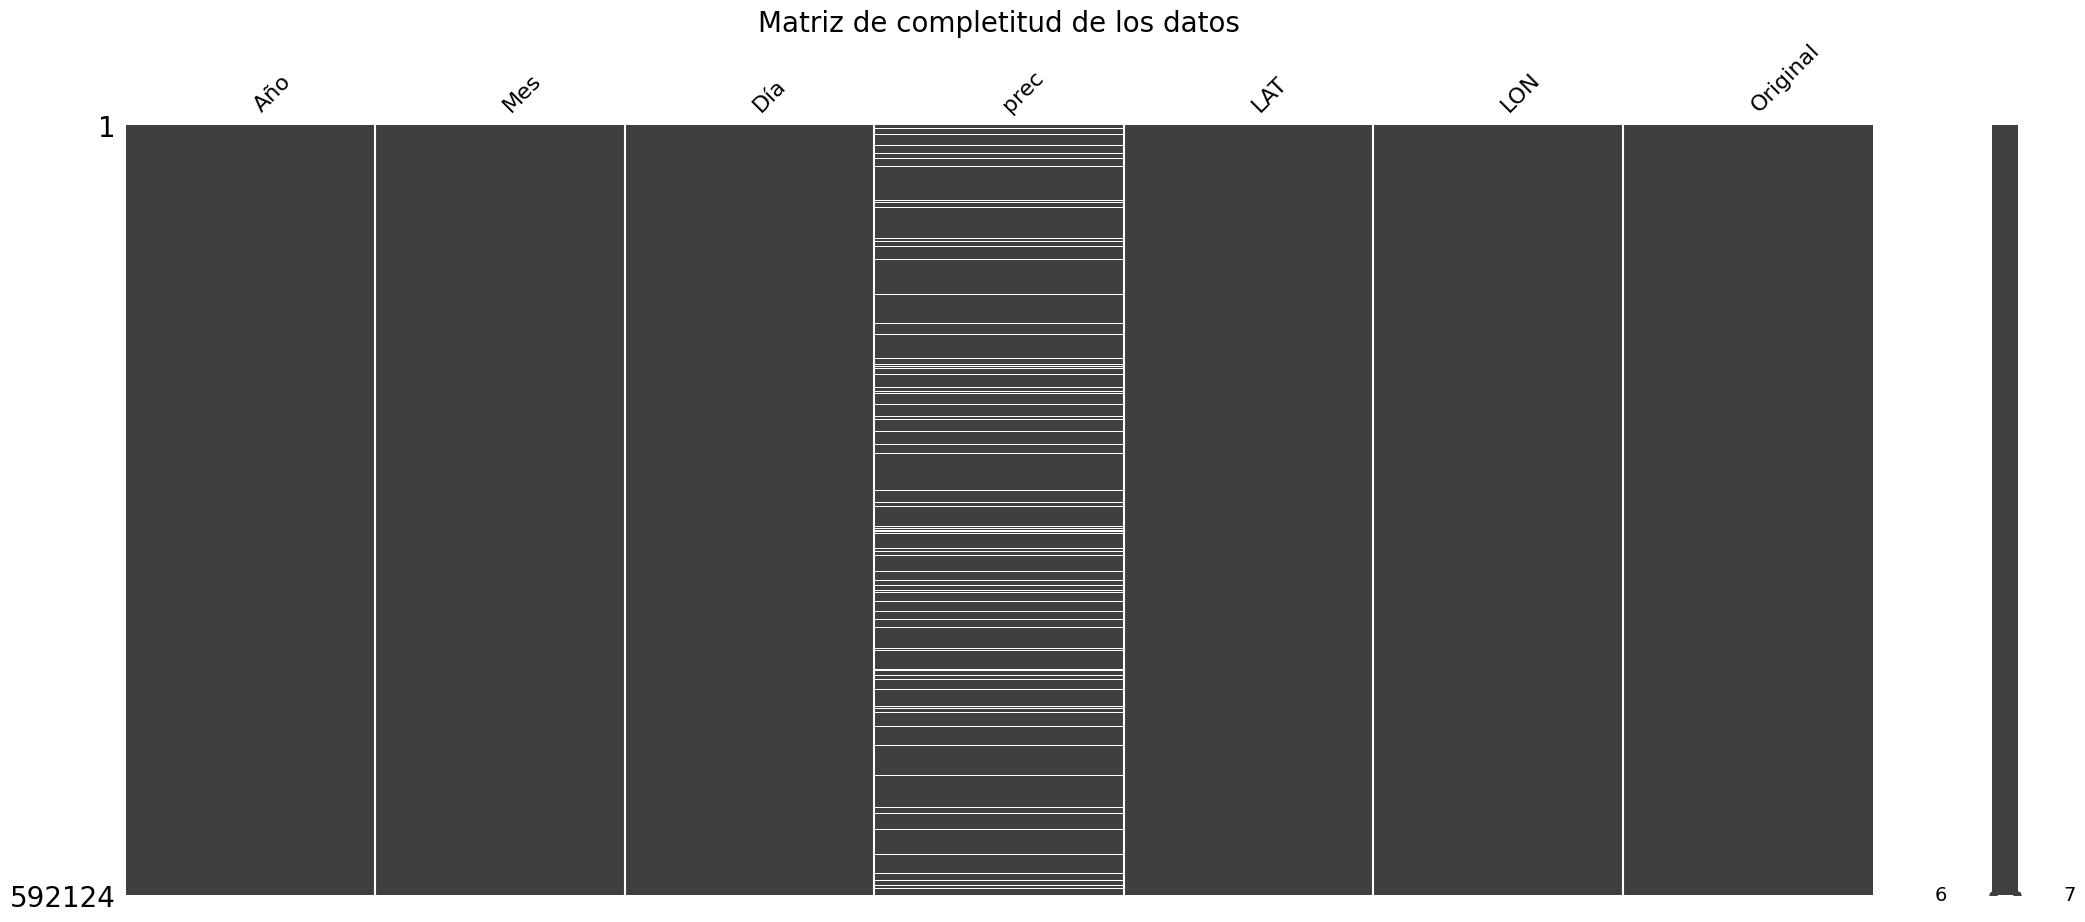

In [23]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt

# Suponemos que 'data' es tu DataFrame

# Visualizar la completitud de los datos con matriz
plt.figure(figsize=(10,6))
msno.matrix(data_completa_mod)
plt.title('Matriz de completitud de los datos', fontsize=20)
plt.show()


In [24]:
soloNAn=na_rows = data_completa_mod[data_completa_mod['prec'].isna()]
soloNAn

,Año,Mes,Día,prec,LAT,LON,Original
8032,2005,6,5,NaN,2.562833,-74.103083,6.0
8033,2005,6,6,NaN,2.562833,-74.103083,4.0
8034,2005,6,7,NaN,2.562833,-74.103083,0.0
8037,2005,6,10,NaN,2.562833,-74.103083,4.0
8106,2005,8,18,NaN,2.562833,-74.103083,1.0
...,...,...,...,...,...,...,...
654364,2008,11,15,NaN,4.260361,-72.564472,0.1
654241,2008,7,15,NaN,4.260361,-72.564472,0.0
654226,2008,6,30,NaN,4.260361,-72.564472,2.0
654220,2008,6,24,NaN,4.260361,-72.564472,2.3


### XGBOOST(imputacion)

In [25]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
##ejemplo de imputacion con boosting
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Crear datos de ejemplo con valores faltantes
np.random.seed(42)
n_samples = 1000
X = np.random.rand(n_samples, 4)
y = np.random.rand(n_samples, 1)
mask = np.random.rand(n_samples, 4) < 0.5
X[mask] = np.nan

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Crear un conjunto de datos de LightGBM para el entrenamiento
train_data = lgb.Dataset(X_train, label=y_train)

# Definir el objetivo del modelo y las características de las variables
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'num_leaves': 31,
    'learning_rate': 0.05,
}

# Entrenar el modelo
model = lgb.train(params, train_data, num_boost_round=2000)

# Predecir los valores faltantes en el conjunto de prueba
preds = model.predict(X_test, verbose_eval=False)

# Calcular el error cuadrático medio (RMSE) entre los valores reales y las predicciones
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: ", rmse)

c:\Users\vhect\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightgbm\basic.py:300: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


[LightGBM] [Warning] Unknown parameter: verbose_eval
RMSE:  0.352435001196264


In [27]:
data = pd.read_csv("Datos/datos_seleccionados_para_modelo_coordenadas.txt",sep=";")
data.head()

,Date,prec,ID,LAT,LON
0,1983-06-09,6.8,32010010,2.562833,-74.103083
1,1983-06-10,17.8,32010010,2.562833,-74.103083
2,1983-06-11,0.0,32010010,2.562833,-74.103083
3,1983-06-12,0.5,32010010,2.562833,-74.103083
4,1983-06-13,6.9,32010010,2.562833,-74.103083


<Figure size 1000x600 with 0 Axes>

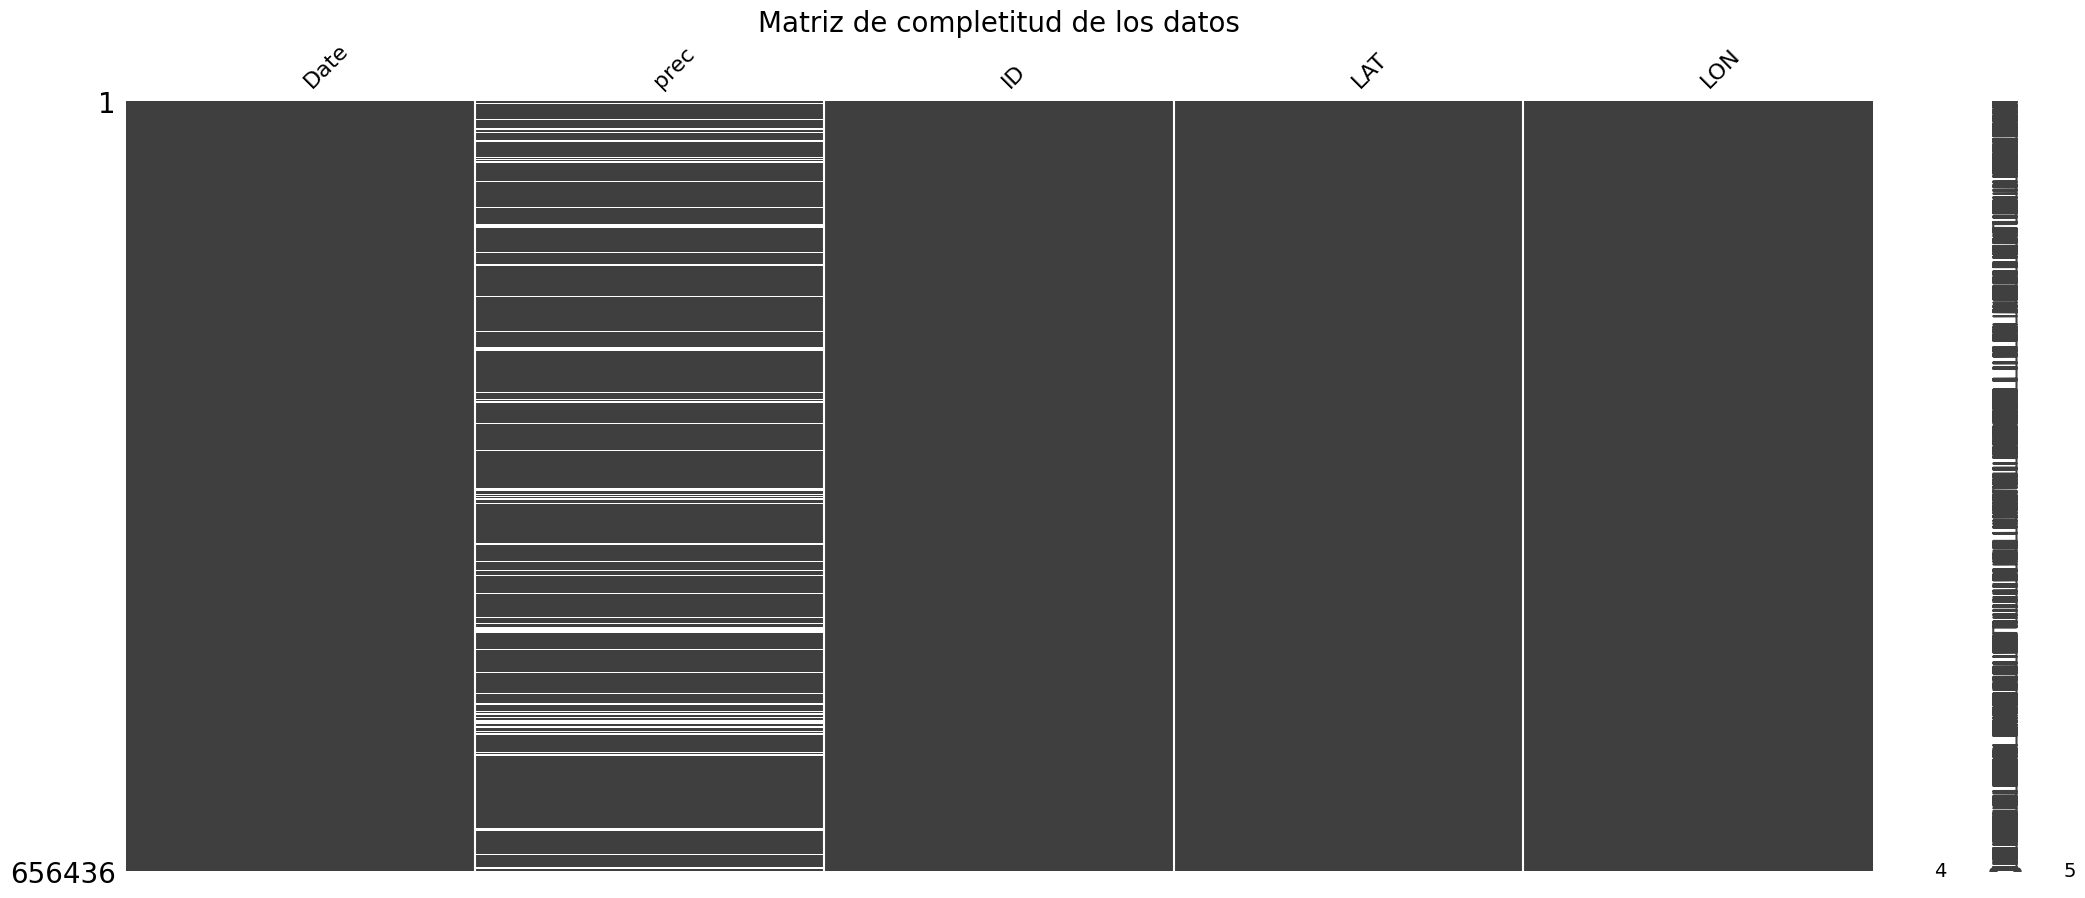

In [28]:
import missingno as msno
import matplotlib.pyplot as plt

# Suponemos que 'data' es tu DataFrame

# Visualizar la completitud de los datos con matriz
plt.figure(figsize=(10,6))
msno.matrix(data)
plt.title('Matriz de completitud de los datos', fontsize=20)
plt.show()

In [29]:
# Calcula la cantidad de datos faltantes por columna en data
missing_data = data.isnull().sum()

# Imprime la cantidad de datos faltantes por columna
print(missing_data)


Date        0
prec    64312
ID          0
LAT         0
LON         0
dtype: int64


In [30]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data = data.drop('Date', axis=1)


In [31]:
data

,prec,ID,LAT,LON,Year,Month,Day
0,6.8,32010010,2.562833,-74.103083,1983,6,9
1,17.8,32010010,2.562833,-74.103083,1983,6,10
2,0.0,32010010,2.562833,-74.103083,1983,6,11
3,0.5,32010010,2.562833,-74.103083,1983,6,12
4,6.9,32010010,2.562833,-74.103083,1983,6,13
...,...,...,...,...,...,...,...
656431,0.1,35185010,4.260361,-72.564472,2014,7,14
656432,9.8,35185010,4.260361,-72.564472,2014,7,15
656433,0.0,35185010,4.260361,-72.564472,2014,7,16
656434,4.5,35185010,4.260361,-72.564472,2014,7,17


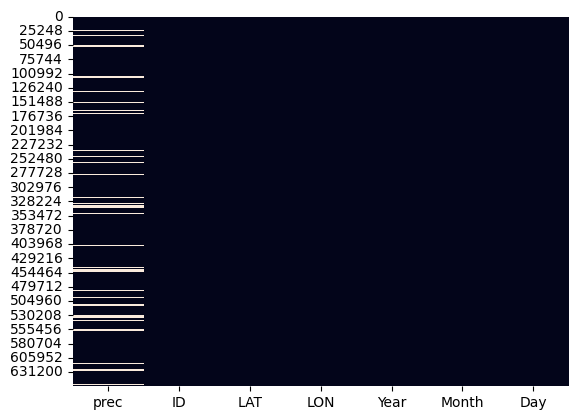

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Crear un mapa de calor de los valores faltantes
sns.heatmap(data.isna(), cbar=False)
plt.show()

In [53]:
## imputación por xgboost a la data tesis
import pandas as pd
import xgboost as xgb
from joblib import Parallel, delayed


def impute_data(train_data):
    # Crea una copia de los datos para evitar el error de "assignment destination is read-only"
    data_copy = train_data.copy()

    # Separa las características (variables independientes) y la columna objetivo
    X_train = data_copy.drop('prec', axis=1)
    y_train = data_copy['prec']

    # Crea y entrena el modelo XGBoost
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    # Utiliza el modelo entrenado para predecir los valores faltantes en los datos
    X_test = data[data['prec'].isnull()].drop('prec', axis=1)
    y_pred = model.predict(X_test)

    # Asigna las predicciones de vuelta a la copia de los datos
    #data_copy.loc[data_copy['prec'].isnull(), 'prec'] = y_pred

    return data_copy

# Paralelizar la imputación para todo el DataFrame
imputed_data = Parallel(n_jobs=-1)(delayed(impute_data)(data[~data['prec'].isnull()]) for _ in range(1))[0]


In [56]:

imputed_data = imputed_data.rename(columns={'prec': 'prec_imputed'})
imputed_data

,prec_imputed,ID,LAT,LON,Year,Month,Day
0,6.8,32010010,2.562833,-74.103083,1983,6,9
1,17.8,32010010,2.562833,-74.103083,1983,6,10
2,0.0,32010010,2.562833,-74.103083,1983,6,11
3,0.5,32010010,2.562833,-74.103083,1983,6,12
4,6.9,32010010,2.562833,-74.103083,1983,6,13
...,...,...,...,...,...,...,...
656431,0.1,35185010,4.260361,-72.564472,2014,7,14
656432,9.8,35185010,4.260361,-72.564472,2014,7,15
656433,0.0,35185010,4.260361,-72.564472,2014,7,16
656434,4.5,35185010,4.260361,-72.564472,2014,7,17


In [57]:
# Calcula la cantidad de datos faltantes por columna en data
missing_data = imputed_data.isnull().sum()

# Imprime la cantidad de datos faltantes por columna
print(missing_data)


prec_imputed    0
ID              0
LAT             0
LON             0
Year            0
Month           0
Day             0
dtype: int64


In [58]:
# Concatenar las columnas 'Precipitacion' de data y imputed_data en un nuevo DataFrame
merged_data = pd.concat([data, imputed_data['prec_imputed']], axis=1)

# Verificar el nuevo DataFrame que contiene ambas columnas
print(merged_data)

        prec        ID       LAT        LON  Year  Month  Day  prec_imputed
0        6.8  32010010  2.562833 -74.103083  1983      6    9           6.8
1       17.8  32010010  2.562833 -74.103083  1983      6   10          17.8
2        0.0  32010010  2.562833 -74.103083  1983      6   11           0.0
3        0.5  32010010  2.562833 -74.103083  1983      6   12           0.5
4        6.9  32010010  2.562833 -74.103083  1983      6   13           6.9
...      ...       ...       ...        ...   ...    ...  ...           ...
656431   0.1  35185010  4.260361 -72.564472  2014      7   14           0.1
656432   9.8  35185010  4.260361 -72.564472  2014      7   15           9.8
656433   0.0  35185010  4.260361 -72.564472  2014      7   16           0.0
656434   4.5  35185010  4.260361 -72.564472  2014      7   17           4.5
656435   0.0  35185010  4.260361 -72.564472  2014      7   18           0.0

[656436 rows x 8 columns]


In [60]:
# data_nas = merged_data[merged_data['prec'].isna()]

# # Filtrar las posiciones con imputaciones en la columna 'prec' de 'imputed_data'
# imputed_nas = imputed_data[imputed_data['prec_imputed'].isna()]

# # Mostrar los resultados
# print("Posiciones con NaN en 'Precipitacion' en data:")
# print(data_nas)

# print("Posiciones con imputaciones en 'prec' en imputed_data:")
# print(imputed_nas)

Posiciones con NaN en 'Precipitacion' en data:
        prec        ID       LAT        LON  Year  Month  Day  prec_imputed
166      NaN  32010010  2.562833 -74.103083  1983     11   22           NaN
327      NaN  32010010  2.562833 -74.103083  1984      5    1           NaN
328      NaN  32010010  2.562833 -74.103083  1984      5    2           NaN
329      NaN  32010010  2.562833 -74.103083  1984      5    3           NaN
330      NaN  32010010  2.562833 -74.103083  1984      5    4           NaN
...      ...       ...       ...        ...   ...    ...  ...           ...
656402   NaN  35185010  4.260361 -72.564472  2014      6   15           NaN
656403   NaN  35185010  4.260361 -72.564472  2014      6   16           NaN
656405   NaN  35185010  4.260361 -72.564472  2014      6   18           NaN
656414   NaN  35185010  4.260361 -72.564472  2014      6   27           NaN
656415   NaN  35185010  4.260361 -72.564472  2014      6   28           NaN

[64312 rows x 8 columns]
Posiciones con 

In [ ]:
merged_data['']

## Bibliografia 

Little, R. J. A., & Rubin, D. B. (2002). Statistical Analysis with Missing Data (Vol. 333). John Wiley & Sons.